In [1]:
import json
import xtrack as xt
import xpart as xp
import xobjects as xo
import PyNAFF
from matplotlib import pyplot as plt
import numpy as np

context = xo.ContextCpu()

#with open('../data/collider_thin.json') as f:
#    dct = json.load(f)

#line = xt.Line.from_dict(dct['lines']['lhcb1'])
#line_edited =line.copy()

collider = xt.Multiline.from_json('../data/collider_thin.json')

line = collider['lhcb1']
for ii in line.elements:
   # if ii is a type 'multipole' 
    if type(ii) == xt.beam_elements.elements.Multipole:
        if len(ii.knl)>2:
            #print(ii)
            ii.knl[2] = 0

line.vars['i_oct_b1'] = 0
line.vars['i_sext_b1'] = 0

line_edited = line.copy()
plt.close('all')

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


In [2]:
#Only one particle
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
line.particle_ref = my_particle
num_turns = 1000
sampling_frequency = 11245.5

num_particles = 3
monitor_ip3 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip5 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip8 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
line.insert_element(index='ip3', element=monitor_ip3, name='mymon3')
line.insert_element(index='ip5', element=monitor_ip5, name='mymon5')
line.insert_element(index='ip8', element=monitor_ip8, name='mymon8')




line.build_tracker()


monitor = xt.ParticlesMonitor(_context=context,
                              start_at_turn=0, stop_at_turn=num_turns,
                              num_particles=num_particles)
line.track(my_particle, num_turns=num_turns, freeze_longitudinal=True)

aux = line.twiss()

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_longitudinal`.


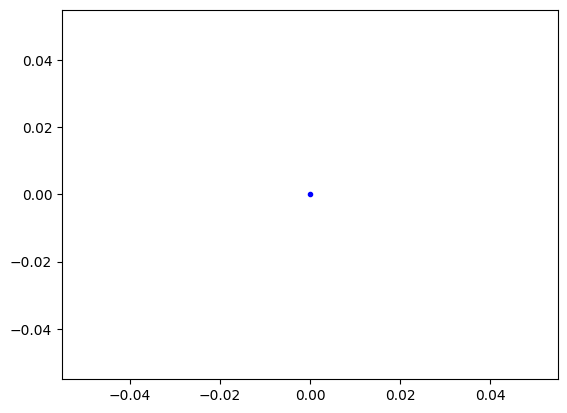

In [3]:
plt.plot(my_particle.x, my_particle.px, '.b') 

In [4]:
monitors = {}  # Create an empty dictionary to store the monitors
#num_particles = 2
#num_turns = 50
line_edited.discard_tracker()
for jj, ii in enumerate((['ip3']+list(aux[:, 'bpm.*']['name']))):
    monitor_name = f"mymon_{ii.replace('.', '_')}"
    monitors[monitor_name] = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, num_particles=num_particles)
    line_edited.insert_element(index=ii,
                                element=monitors[monitor_name], 
                                name=monitor_name)
                            


In [5]:
# Exciter is working


f = 10
phi = 0
A = 1
sampling_frequency = 11245.5
total_time = num_turns / sampling_frequency
time = np.arange(0, total_time, 1/sampling_frequency)
samples = A * np.sin(2*np.pi*f*time + phi)


exciter = xt.Exciter(_context = context,
    samples = samples,
    sampling_frequency = sampling_frequency,
    duration = 0.02,  # defaults to waveform duration
    frev = sampling_frequency,
    start_turn = num_turns/2,  # default, seconds
    knl = [0.001],  # default, no kick
     # default, no kick
    #knl = [1],
    #ksl = []
)
print(dir(line_edited.insert_element))

# Add it to the line for tracking as usual
'''
for i in range(0, num_turns):
    while i < num_turns:
        line.insert_element(
            element = exciter,
            name = 'RF_KO_EXCITER',
            index = 42,
        )
        i += 1    
'''


line_edited.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

#insertion of the element in the beamline, the phase should be broken due to the kick



['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [6]:

line_edited.particle_ref = my_particle
line_edited.discard_tracker()
line_edited.build_tracker()
#print(line_edited.twiss()[:,'mymon_.*'])
#len(line_edited.twiss()[:,'mymon_.*']['mux'])


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [7]:
# generates a matched gaussian bunch and tracks it through the line
# the line is then edited to include BPMs and the bunch is tracked again
# the BPMs are then used to calculate the emittance of the bunch
# 
particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])

particle_0 = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])
#particle_0 = xp.Particles(
                 #   mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=0.003)

#particles = xp.generate_matched_gaussian_bunch(line=line,
                                           #    num_particles=num_particles,
                                           #    nemitt_x=2.5e-6,
                                           #    nemitt_y=2.5e-6,
                                           #    sigma_z=9e-2, particle_ref=particles)
line_edited.track(particles, num_turns=num_turns, freeze_longitudinal=True)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Text(0, 0.5, 'px [rad]')

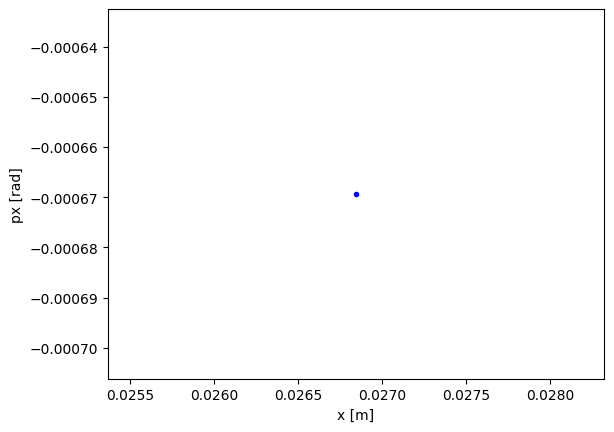

In [8]:
plt.plot(particles.x, particles.px, '.b')
plt.xlabel('x [m]')
plt.ylabel('px [rad]')

15000
1000


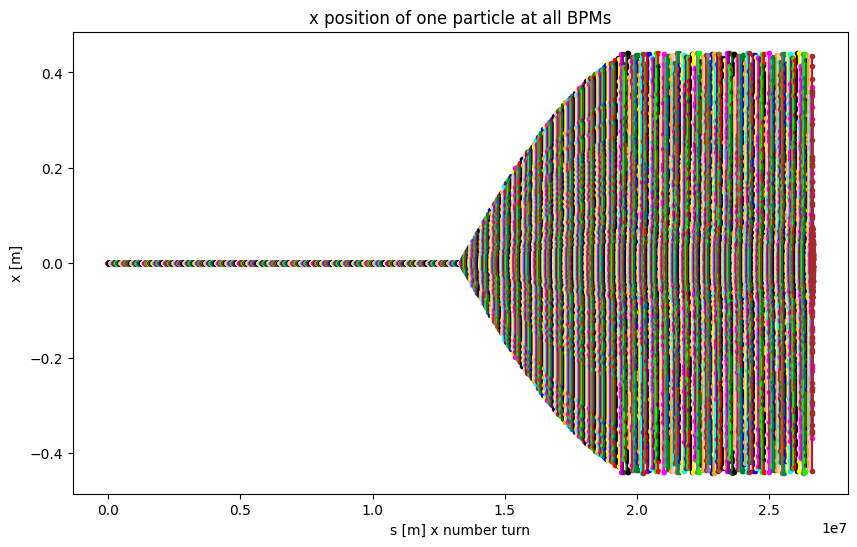

In [9]:

plt.figure(figsize=(10, 6))
#s_list = [monitors[ii].s[0,0] for ii in monitors]
#print(s_list[0])
#for jj in range(len(monitors)
n = np.arange(0, num_turns)
twiss = line_edited.twiss()
mux = twiss[:,'mymon.*'].mux
betx = twiss[:,'mymon.*'].betx
#print(len(twiss['mux']))
#mux = twiss.mux
#print(len(mux))
#print(n)
x_list_all = []
x_list0 = []  
s_list0 = []
c = 1000*['red', 'green', 'blue', 'black', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'brown', 'purple', 'gray', 'olive', 'lime', 'teal']
print(len(c))
for jj in n:
    #print(jj)
    x_list = [monitors[ii].x[0,jj] for ii in monitors]   #monitors[ii].x[i,j], i is the particle number, j is the turn number

    #x_list0 = [monitors[ii].x[0,0] for ii in monitors]
    s_list = [monitors[ii].s[0,jj] for ii in monitors]
    x_list_all.extend(x_list)
    #print(len(x_list_all))
    mon = monitors['mymon_ip3'].x[0,jj]  #just the first particle, one monitor for all turns
    mon_position = monitors['mymon_ip3'].s[0,jj]    
    #mux = twiss[:,'mymon_ip3'].mux
    #print(mux)
    x_list0.append(mon)  
    s_list0.append(mon_position) #

    #print(s_list)
    #plt.plot(s_list+(jj)*s_list[-1], x_list, '.-r')
    plt.plot((s_list + jj*s_list[-1]), x_list, '.-', color=c[jj])
    
    
    #plt.plot(mux, x_list/np.sqrt(betx), '.-r')
    #plt.xlim(0,4)

    
#plt.plot(s_list, x_list0, 1'.-b')
#print(s_list0)
x = np.fft.fft(x_list_all)

plt.xlabel('s [m] x number turn')
plt.ylabel('x [m]')
plt.title('x position of one particle at all BPMs')
print(len(x_list0))
plt.show()

#fft_try = abs(np.fft.fft(x_list0 - np.mean(x_list0)))
fft_try = np.fft.fft(x_list0) # fft of one monitor for all turns
fft_try = fft_try/len(fft_try)*2 #normalization
fft = fft_try.real + 1j*fft_try.imag 
# 
fft_used = abs(fft) - np.mean(abs(fft))
#freq_try = np.fft.fftfreq(len(fft_used), d = 1/len(fft_used))
#freq_try = np.fft.fftfreq(len(x_list0), d = 1/len(x_list0))

freq_try  =  np.linspace(0, sampling_frequency, len(fft_used))

plt.show()




Text(0, 0.5, 'x [m]')

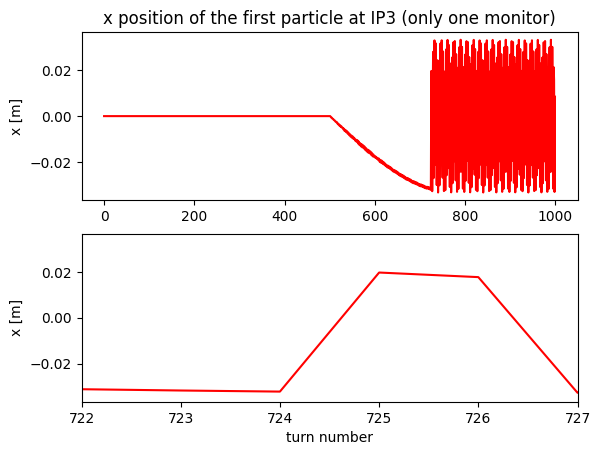

In [10]:
plt.subplot(2,1,1)
plt.title('x position of the first particle at IP3 (only one monitor)')
plt.plot(np.arange(num_turns), x_list0, '-r') 
plt.ylabel('x [m]')
plt.subplot(2,1,2)
plt.plot(np.arange(num_turns), x_list0, '-r')
plt.xlim(722, 727)
plt.xlabel('turn number')
plt.ylabel('x [m]')


amplitude_fit -0.002962317334161469
frequency_fit 0.9998902830044337


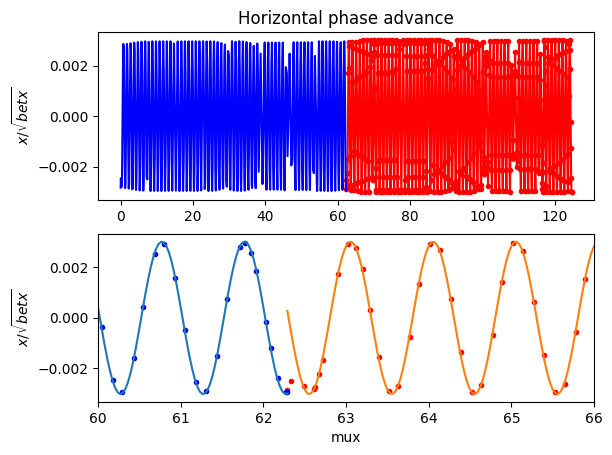

In [11]:
# Data for only the first turn, all BPMs
#print('betx', betx)
#y_data = x_list_all[len(mux)+1:len(mux)*2+1]/np.sqrt(betx)
#y_data_1 = x_list_all[0:len(mux)]/np.sqrt(betx)
y_data_1 = x_list_all[len(mux)*int(num_turns/2+2):len(mux)*int(num_turns/2+3)]/np.sqrt(betx)
y_data = x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx)
y_data_0 = x_list_all[len(mux)*int(num_turns/2+0):len(mux)*int(num_turns/2+1)]/np.sqrt(betx)
y_data_0 = x_list_all[len(mux)*int(722):len(mux)*int(723)]/np.sqrt(betx)
y_data = x_list_all[len(mux)*int(723):len(mux)*int(724)]/np.sqrt(betx)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Fit the sine function to the data
initial_guess = [1, 1, 0, 1]  # Initial guess for the parameters
fit_params, _ = curve_fit(sine_function, mux, y_data_0, p0=initial_guess)
fit_params1, _1 = curve_fit(sine_function, mux, y_data, p0=initial_guess)
# Extract the fitted parameters
amplitude_fit, frequency_fit, phase_fit, offset_fit = fit_params
amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1 = fit_params1

x_fine = np.linspace(min(mux), max(mux), 2000)
# Generate the fitted curve using the fitted parameters
y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit1 = sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1)

fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))
y_fine = fitted_sine_interpolated(x_fine)
y_fine_1 = fitted_sine_interpolated(x_fine)


plt.subplot(2,1,1)

#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
plt.plot(mux+mux[-1], y_data, '.-r')
plt.plot(mux, y_data_0, '-b')
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(x_fine, y_fine)
#plt.xlim(0,10)
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
plt.title('Horizontal phase advance')
plt.ylabel('$x/\sqrt{betx}$')
plt.subplot(2,1,2)
#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
#plt.plot(mux, y_data, '.-r')#
plt.plot(mux + mux[-1], y_data, '.r')
plt.plot(mux, y_data_0, '.b')
plt.plot(x_fine, y_fine)
plt.plot(x_fine+x_fine[-1], y_fine_1)
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
#plt.xlim(mux[-1]*2-mux[10], mux[-1]*2+ mux[10])
plt.xlim(60, 66)
#print('mux', twiss[:,'mymon.*'].mux)
#print('len mux', len(twiss[:,'mymon.*'].mux))
#print('twiss.mux', len(twiss.mux))

plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$')
print('amplitude_fit', amplitude_fit)
print('frequency_fit', frequency_fit)

The 10 Hz is now -3486.105


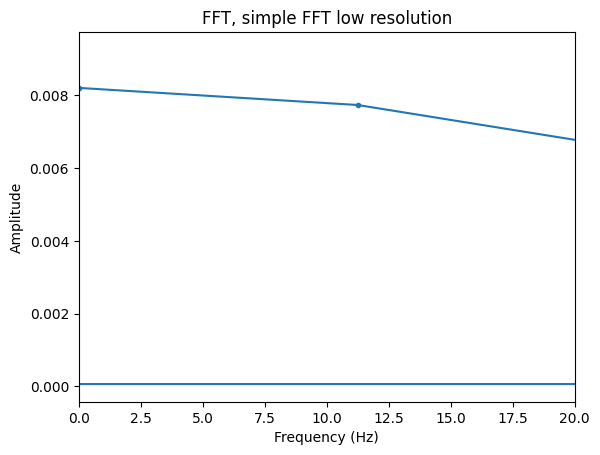

In [12]:
fft_try = np.fft.fft(x_list0)

# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.fftfreq(len(fft_normalized), d=1/sampling_frequency)


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)


# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT, simple FFT low resolution")
plt.xlim(0, sampling_frequency / 2)  # Nyquist frequency
plt.xlim(0,20)

#print('The tune is', freq_try[np.argmax(fft_amplitude)]/sampling_frequency)
print('The 10 Hz is now', freq_try[np.argmax(fft_amplitude)])
plt.show()

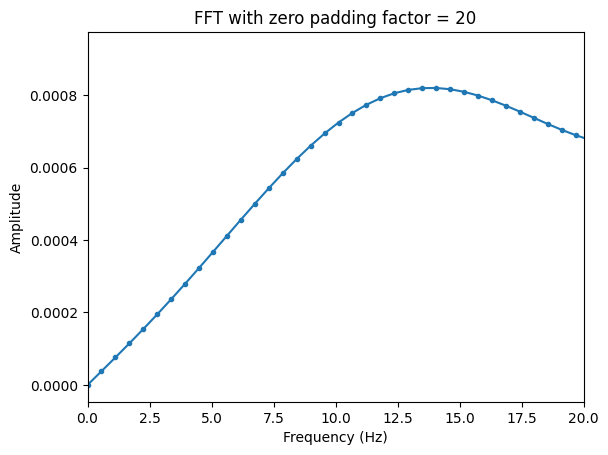

10 Hz 14.056875


In [13]:
# Zero padding
zero_padding_factor = 20
fft_try = np.fft.rfft(x_list0-np.mean(x_list0), n = len(x_list0) * zero_padding_factor)
#print(len(fft_try))
# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.rfftfreq(len(x_list0) *  zero_padding_factor, d=1/sampling_frequency)
#print(len(freq_try))


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)
#print(fft_amplitude)


# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT with zero padding factor = 20")
#plt.xlim(0.22, 0.4)  # Nyquist frequency
plt.xlim(0,20)  
plt.show()
#print('The tune is', freq_try[np.argmax(fft_amplitude)]/sampling_frequency)
print('10 Hz', freq_try[np.argmax(fft_amplitude[0:1000])])

In [ ]:
# Kick - a wave that is applied to the signal periodically, we choose a sine wave
phi = 0
f = 10 # Hz
A = 2
t = np.arange(10000)/sampling_frequency  # n = 10000, should be 50 in this case, but then the resolution is too low res =  sampling_frequency / frequency
print(t)
#t = np.linspace(0, 1, 50)
print(n)
kick = A * np.sin(2*np.pi*f*t + phi)
plt.plot(np.arange(10000), kick)

# example of a kick
'''
total_time = n_turns / f_rev
time = np.arange(0, total_time, 1/sampling_freq)
samples = np.sin(2*np.pi*f_ex*time + phi)


exciter = xt.Exciter(_context = ctx,
    samples = samples,
    sampling_frequency = sampling_freq,
    duration = None,  # defaults to waveform duration
    frev = f_rev,
    start_turn = 0,  # default, seconds
    knl = KNL,
    ksl = KSL,
)

# Add it to the line for tracking as usual
line.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

insertion of the element in the beamline, the phase should be broken due to the kick
'''

In [ ]:

#collider.build_trackers()
betx = twiss['betx'][0]
bety = twiss['bety'][0]
normal_emitt_x = 2.5e-6
normal_emitt_y = 2.5e-6

sigma_x = np.sqrt(betx*normal_emitt_x/(particles.gamma0*particles.beta0))[0]
sigma_y = np.sqrt(bety*normal_emitt_y/(particles.gamma0*particles.beta0))[0]
x = np.linspace(sigma_x, 3*sigma_x, 5)
px = np.zeros(5)
y = np.zeros(5)
py = np.zeros(5)
zeta = np.zeros(5)
delta = np.zeros(5)

particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=x)

collider['lhcb1'].track(particles, num_turns=num_turns,
              turn_by_turn_monitor=True)

print(x)

ys = collider['lhcb1'].record_last_track.y
xs = collider['lhcb1'].record_last_track.x
print(xs)
qx_i = []
qy_i = []
for ii in range(len(x)):
    qx_i.append(PyNAFF.naff(xs[ii,:], turns=499)[0][1])
    qy_i.append(PyNAFF.naff(ys[ii,:], turns=499)[0][1])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.plot(qx_i,qy_i,'-o')
plt.plot(x**2/sigma_x**3,qx_i,'-o')
plt.xlabel(r'$x^{2}$[$\sigma^{2}$]', size = 20)
#plt.xlabel(r'qx', size = 20)

plt.ylabel(r'qx', size = 20)
plt.grid()

In [ ]:
# 50 turns, tune -.37, reference value is -0.352
plt.plot(freq_try, fft_try, '.-r')
plt.xlim(0.1, 0.5)
# find the tune
twiss = line_edited.twiss()
twiss.dqx
ind = np.where(fft_try==np.max(fft_try))
fft_try[ind]
freq_try[ind]
